In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

/home/xiuminke/miniconda3/envs/ml12/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/xiuminke/miniconda3/envs/ml12/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [3]:
# 载入MNIST数据集
# dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())
# torchvision.datasets.MNIST?

In [4]:
import os
# import torch
from torchvision import transforms, datasets
# from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError

import os
from torchvision import datasets, transforms
from PIL import Image, UnidentifiedImageError

class SafeImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None,
                 include_prefixes=None,             # 例如 ['2','3',...,'22']
                 only_jpg_with_underscore=False):   # 仅文件名含 '_' 的 .jpg
        self.include_prefixes = include_prefixes
        self.only_jpg_with_underscore = only_jpg_with_underscore
        super().__init__(root=root, transform=transform)

        kept, skipped = [], 0
        for path, target in self.samples:
            fname = os.path.basename(path)
            dname = os.path.basename(os.path.dirname(path))
            prefix = dname.split()[0] if dname else ""

            if self.include_prefixes is not None and prefix not in self.include_prefixes:
                continue
            if self.only_jpg_with_underscore:
                if not fname.lower().endswith(".jpg") or "_" not in fname or fname.startswith("._"):
                    continue
            try:
                with Image.open(path) as im:
                    im.verify()
            except (UnidentifiedImageError, OSError):
                skipped += 1
                continue
            kept.append((path, target))

        # 可选：只保留有样本的类别并重映射 targets（保证 classes 与实际样本一致）
        present_classes = sorted({os.path.basename(os.path.dirname(p)) for p, _ in kept})
        class_to_idx = {cls: i for i, cls in enumerate(present_classes)}
        remapped = [(p, class_to_idx[os.path.basename(os.path.dirname(p))]) for p, _ in kept]

        self.classes = present_classes
        self.class_to_idx = class_to_idx
        self.samples = remapped
        self.imgs = remapped
        self.targets = [t for _, t in remapped]
        print(f"SafeImageFolder: kept={len(remapped)} skipped={skipped} classes={len(self.classes)}")

    def find_classes(self, directory):
        classes = []
        for d in sorted(os.listdir(directory)):
            p = os.path.join(directory, d)
            if not os.path.isdir(p):
                continue
            prefix = d.split()[0] if d else ""
            if self.include_prefixes is None or prefix in self.include_prefixes:
                classes.append(d)
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# 路径
root = "/mnt/d/forCoding_data/ML_runCodeFromBook/HuggingFace扩散模型/originalData/Q版大明衣冠图志"

# 与 MNIST 类似的变换（返回 C×H×W 的 float 张量）
tf = transforms.Compose([
    transforms.Resize((128, 128)),        # 若不需要固定尺寸可移除
    transforms.ToTensor(),                # [0,1]
    # 如需与之前代码一致的 [-1,1]，可加：transforms.Normalize([0.5]*3, [0.5]*3)
])

# 仅加载 2..22 目录、带下划线的 .jpg，且自动跳过坏图
include = [str(i) for i in range(2, 23)]
dataset = SafeImageFolder(
    root=root,
    transform=tf,
    include_prefixes=include,
    only_jpg_with_underscore=True
)

# 与 MNIST 相同的用法：随机划分训练/测试并迭代
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# 取一个样本（形式与 MNIST 一样）
img, label = dataset[0]
print(img.shape, label)  # 例如 torch.Size([3, 128, 128]), label 为 int
print("classes:", dataset.classes)

SafeImageFolder: kept=169 skipped=0 classes=18
torch.Size([3, 128, 128]) 0
classes: ['10 军校冠服', '11 军士巾服', '12 状元进士生员冠服', '13 吏员皂隶巾服', '14 士庶巾服', '15 士庶妻冠服', '16 僧道冠服', '17 仆役巾服', '18 杂流巾服', '19 乐舞巾服', '2 皇帝冠服', '20 婚礼冠服', '21 丧礼冠服', '3 皇后冠服', '6 皇子公主冠服', '7 文武官冠服', '8 命妇冠服', '9 宫人舍人使官服']


In [5]:
# 创建数据加载器
train_dataloader = DataLoader(dataset, batch_size=8,shuffle=True)

Input shape: torch.Size([8, 3, 128, 128])
Labels: tensor([10,  5,  5,  4, 16,  1,  4, 12])


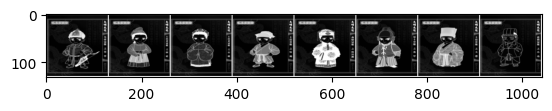

In [6]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [7]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=18, class_emb_size=4):
        super().__init__()
        # 这个网络层会把数字所属的类别映射到一个长度为class_emb_size的特征向量上
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # self.model是一个不带生成条件的UNet模型，在这里，我们给它添加了额外的
        # 输入通道，用于接收条件信息
        self.model = UNet2DModel(
            sample_size=28, # 所生成图片的尺寸
            in_channels=3 + class_emb_size, # 加入额外的输入通道，用于施加生成条件
            out_channels=1, # 输出结果的通道数
            layers_per_block=2, # 设置一个UNet模块有多少个残差连接层
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D", # 常规的ResNet下采样模块
                "AttnDownBlock2D", # 含有spatial self-attention的
                "AttnDownBlock2D", # ResNet下采样模块
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D", # 含有spatial self-attention的ResNet上采样模块
                "UpBlock2D", # 常规的ResNet下采样模块
            ),
        )
    
    # 此时扩散模型的前向计算就会含有额外的类别标签作为输入了
    def forward(self, x, t, class_labels):
        bs, ch, w, h = x.shape
        # 类别条件将会以额外通道的形式输入
        class_cond = self.class_emb(class_labels) # 将类别映射为向量形式，
        # 并扩展成类似于(bs, 4, 28, 28)的张量形状
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # 将原始输入和类别条件信息拼接到一起
        net_input = torch.cat((x, class_cond), 1) # (bs, 7, 28, 28)
        # 使用模型进行预测
        # print("xxxxxxxxxyy", x.shape, net_input.shape, class_labels.shape)
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
# 创建一个调度器
noise_scheduler = DDPMScheduler(num_train_timesteps=1000,beta_schedule='squaredcos_cap_v2')
# 定义数据加载器
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10
net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = [] # 记录损失值
# 训练开始
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # 获取数据并添加噪声
        x = x.to(device) * 2 - 1 # 数据被归一化到区间(-1, 1)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999,(x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise,timesteps)
        # 预测
        pred = net(noisy_x, timesteps, y) # 注意这里也输入了类别标签y
        # 计算损失值
        loss = loss_fn(pred, noise) # 判断预测结果和实际的噪声有多接近
        # 梯度回传，参数更新
        opt.zero_grad()
        loss.backward()
        opt.step()
        # 保存损失值
        losses.append(loss.item())
    # 输出损失值
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')
# 可视化训练损失，效果如图5-17所示
plt.plot(losses)

  0%|                                                                                             | 0/2 [00:00<?, ?it/s]

111
222


/home/xiuminke/miniconda3/envs/ml12/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([128, 3, 128, 128])) that is different to the input size (torch.Size([128, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


333


 50%|██████████████████████████████████████████                                          | 1/2 [02:55<02:55, 175.73s/it]

111
222


/home/xiuminke/miniconda3/envs/ml12/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([41, 3, 128, 128])) that is different to the input size (torch.Size([41, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:07<00:00, 123.61s/it]


Finished epoch 0. Average of the last 100 loss values: 0.024269


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]

111
222
333


 50%|██████████████████████████████████████████                                          | 1/2 [04:01<04:01, 241.71s/it]

111
222
333


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [05:10<00:00, 155.45s/it]


Finished epoch 1. Average of the last 100 loss values: 0.041971


  0%|                                                                                             | 0/2 [00:00<?, ?it/s]

111
222
333


In [ ]:
# 准备一个随机噪声作为起点，并准备我们想要的图片的标签
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
# 采样循环
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample
# 显示结果，如图5-18所示
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1,1),nrow=8)[0], cmap='Greys')